<a target="_blank" href="https://colab.research.google.com/github/vectice/GettingStarted/blob/main/24.1/samples/autolog/CDT_example_autolog.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Credit Default Risk


In [ ]:
%pip install vectice -U

## Imports


In [3]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import vectice
from vectice import autolog

autolog.config(
  api_token = "oB5OQWKOg.Gn9QE8yRGW7mN4jxd0ZaAoB5OQWKOgLz3P6rlk2bVDwXYMpevJ",
  host = 'https://app.vectice.com',
  phase = 'PHA-4363',
)

Welcome, bdaversa. You`re now successfully connected to Vectice.
Phase 'Modeling' successfully retrieved.

For quick access to the Phase in the Vectice web app, visit:
https://app.vectice.com/browse/phase/PHA-4363

Autolog is continuously evolving to enhance supported libraries, environments, and functionalities to provide an improved user experience.
For detailed information, supported libraries and environments please consult the documentation: https://api-docs.vectice.com/reference/vectice/autolog/


## Read in Data 

In [15]:
from sklearn.model_selection import train_test_split
# Training data
application_cleaned = pd.read_csv('/Users/bryandaversa/Vectice/GettingStarted/perso/Demo-bank/application_train.csv')
app_train_feat, app_test_feat = train_test_split(application_cleaned, test_size=0.15, random_state=42)
# Separate the target variable from the testing set
target_variable = 'TARGET'
app_test_feat_target = app_test_feat[target_variable]
app_test_feat = app_test_feat.drop(target_variable, axis=1)

# Print the shapes of the resulting dataframes
print('Training data shape: ', app_train_feat.shape)
print('Testing shape: ', app_test_feat.shape)
print('Testing target shape: ', app_test_feat_target.shape)


Training data shape:  (261384, 122)
Testing shape:  (46127, 121)
Testing target shape:  (46127,)


# Feature engineering

### Label Encoding and One-Hot Encoding

In [23]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train_feat:
    if app_train_feat[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train_feat[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train_feat[col])
            # Transform both training and testing data
            app_train_feat[col] = le.transform(app_train_feat[col])
            app_test_feat[col] = le.transform(app_test_feat[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


In [24]:
# one-hot encoding of categorical variables
app_train_feat = pd.get_dummies(app_train_feat)
app_test_feat = pd.get_dummies(app_test_feat)
train_labels = app_train_feat['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train_feat, app_test_feat = app_train_feat.align(app_test_feat, join = 'inner', axis = 1)

# Add the target back in
app_train_feat['TARGET'] = train_labels


# Create an anomalous flag column
app_train_feat['DAYS_EMPLOYED_ANOM'] = app_train_feat["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train_feat['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


app_test_feat['DAYS_EMPLOYED_ANOM'] = app_test_feat["DAYS_EMPLOYED"] == 365243
app_test_feat["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
print('Training Features shape: ', app_train_feat.shape)
print('Testing Features shape: ', app_test_feat.shape)
print('There are %d anomalies in the test data out of %d entries' % (app_test_feat["DAYS_EMPLOYED_ANOM"].sum(), len(app_test_feat)))

Training Features shape:  (261384, 244)
Testing Features shape:  (46127, 243)
There are 0 anomalies in the test data out of 46127 entries


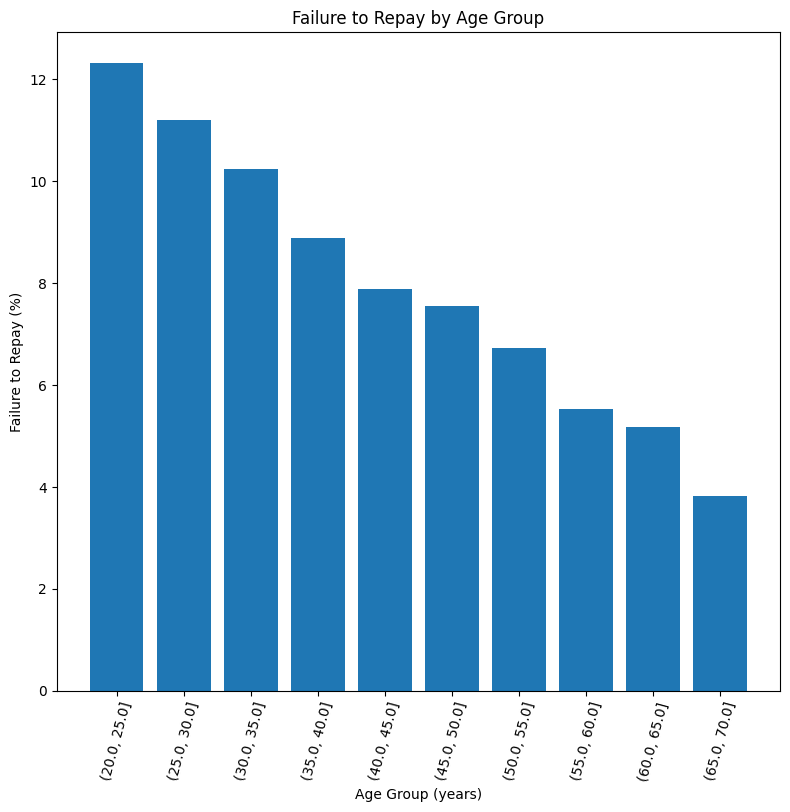

In [25]:
# Age information into a separate dataframe
app_train_feat['DAYS_BIRTH'] = abs(app_train_feat['DAYS_BIRTH'])
app_train_feat['YEARS_BIRTH'] = app_train_feat['DAYS_BIRTH'] / 365

# Bin the age data
app_train_feat['YEARS_BINNED'] = pd.cut(app_train_feat['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(app_train_feat.groupby('YEARS_BINNED').mean().index.astype(str), 100 * app_train_feat.groupby('YEARS_BINNED').mean()['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.tight_layout()
plt.savefig("Failure to repay by age group.png")

plt.title('Failure to Repay by Age Group')
app_train_feat = app_train_feat.drop(columns=['YEARS_BINNED', 'YEARS_BIRTH'])

Text(0.5, 1.0, 'Correlation Heatmap')

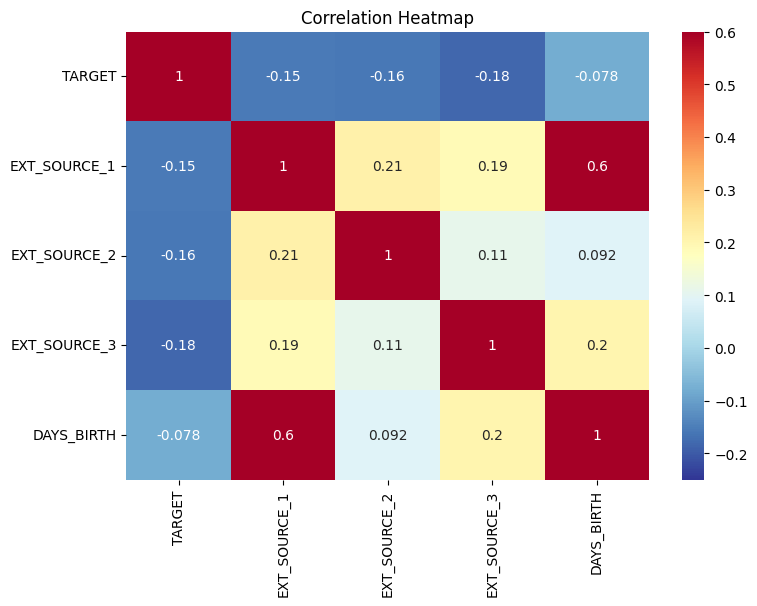

In [26]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(app_train_feat[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.tight_layout()
plt.savefig("Correlation.png")

plt.title('Correlation Heatmap')

In [27]:
def plot_feature_importances(features, feature_importance_values):
    
    df = pd.DataFrame({'feature': features, 'importance': feature_importance_values}).sort_values('importance', ascending = False).reset_index()
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); 
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importances.png')
    plt.show()

In [28]:
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in app_train_feat:
    train_no_missing = app_train_feat.drop(columns = ['TARGET'])

features = list(train_no_missing.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')
# Fit on the training data
imputer.fit(train_no_missing)

# Transform both training and testing data
train_no_missing = pd.DataFrame(imputer.transform(train_no_missing), columns=features).set_index('SK_ID_CURR')
test_no_missing = pd.DataFrame(imputer.transform(app_test_feat), columns=features).set_index('SK_ID_CURR')

# Modeling

ROC AUC Score: 0.7287259725559775
F1 Score: 0.26808315299363894
Recall Score: 0.5499058380414312


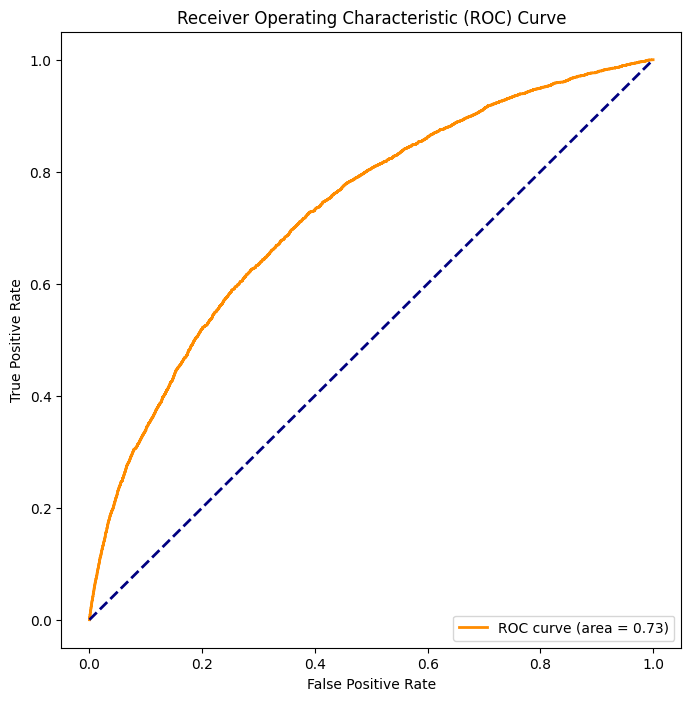

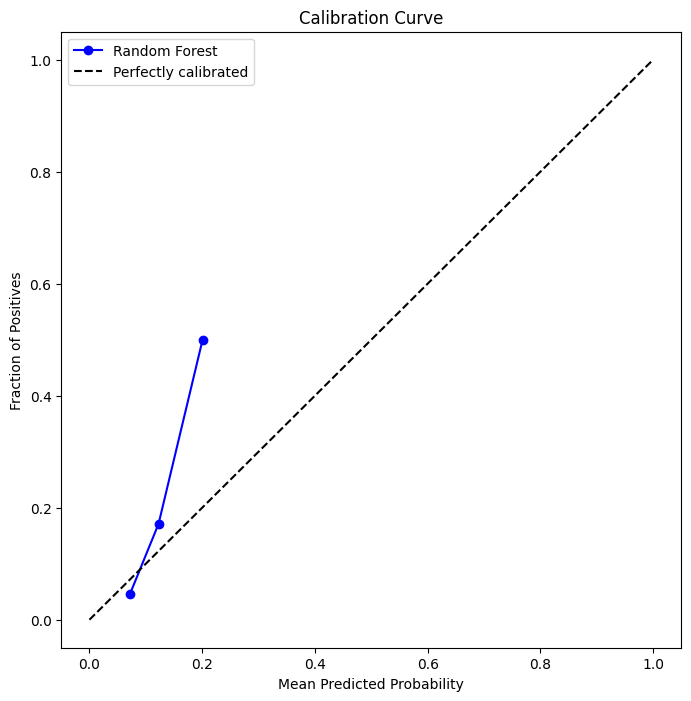

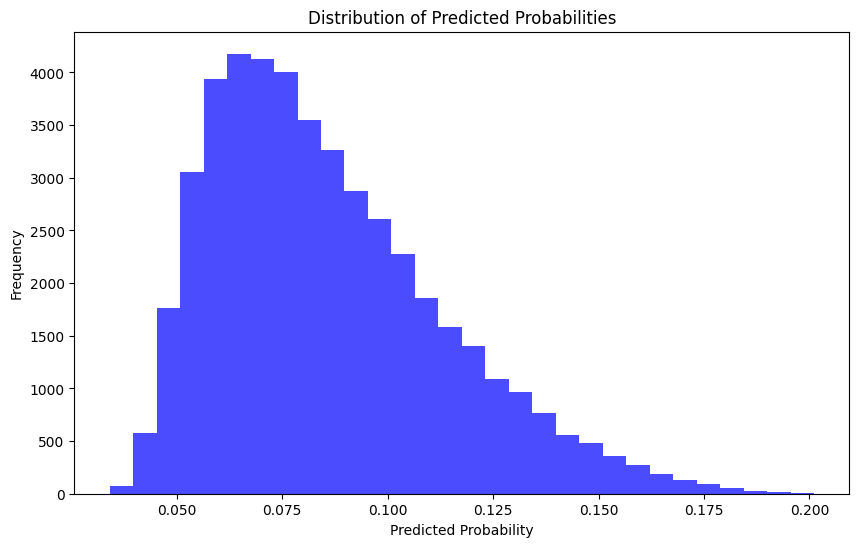

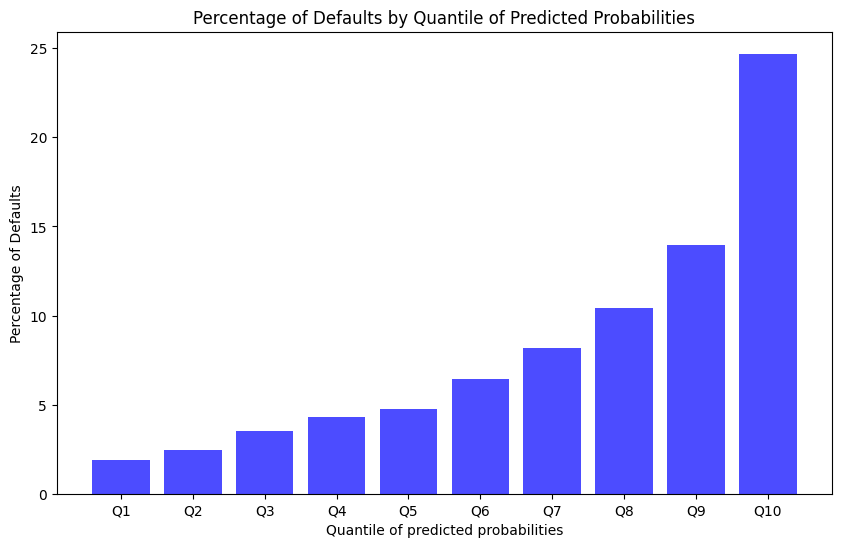

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, roc_curve, auc
from sklearn.calibration import calibration_curve


# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, min_samples_leaf=0.01, n_jobs = -1)
features = list(train_no_missing.columns)
# Train on the training data
random_forest.fit(train_no_missing, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_

# Make predictions on the test data
predictions = random_forest.predict_proba(test_no_missing)[:, 1]

roc_auc = roc_auc_score(app_test_feat_target.values, predictions)
# Sort instances based on predicted probabilities
sorted_indices = np.argsort(predictions)[::-1]
sorted_labels = app_test_feat_target.iloc[sorted_indices]

# Define the desired percentage (e.g., 25%)
desired_percentage = 0.25

# Identify the threshold probability corresponding to the desired percentage
threshold_index = int(desired_percentage * len(predictions))
threshold_probability = predictions[sorted_indices[threshold_index]]

# Apply the threshold to classify instances
binary_predictions = (predictions >= threshold_probability).astype(int)

# Calculate the recall at the desired percentage
recall = recall_score(app_test_feat_target.values, binary_predictions)
f1 = f1_score(app_test_feat_target.values,binary_predictions)

metric = {"auc": float(roc_auc),
          f"recall at {desired_percentage}%": float(recall),
          f"f1_score at {desired_percentage}%":float(f1)}

print("ROC AUC Score:", roc_auc)
print("F1 Score:", f1)
print("Recall Score:", recall)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(app_test_feat_target.values, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()

# Plot calibration curve
prob_true, prob_pred = calibration_curve(app_test_feat_target.values, predictions, n_bins=10)

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest', linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc="upper left")
plt.savefig("calibration.png")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.savefig("Prediction_distribution.png")
plt.ylabel('Frequency')
plt.show()

# Create a DataFrame with predicted probabilities and true labels
df_results = pd.DataFrame({'Probability': predictions, 'Default': app_test_feat_target.values})

# Sort instances based on predicted probabilities
df_results = df_results.sort_values(by='Probability', ascending=False)

# Divide the sorted instances into quantiles (e.g., deciles)
num_quantiles = 10
df_results['Quantile'] = pd.qcut(df_results['Probability'], q=num_quantiles, labels=False, duplicates='drop')

# Calculate the percentage of defaults in each quantile
quantile_defaults = df_results.groupby('Quantile')['Default'].mean() * 100

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(quantile_defaults.index, quantile_defaults.values, color='blue', alpha=0.7)
plt.xlabel('Quantile of predicted probabilities')
plt.ylabel('Percentage of Defaults')
plt.title('Percentage of Defaults by Quantile of Predicted Probabilities')
plt.xticks(ticks=quantile_defaults.index, labels=[f'Q{i + 1}' for i in quantile_defaults.index])
plt.savefig("Percentage of Defaults by Quantile.png")
plt.show()


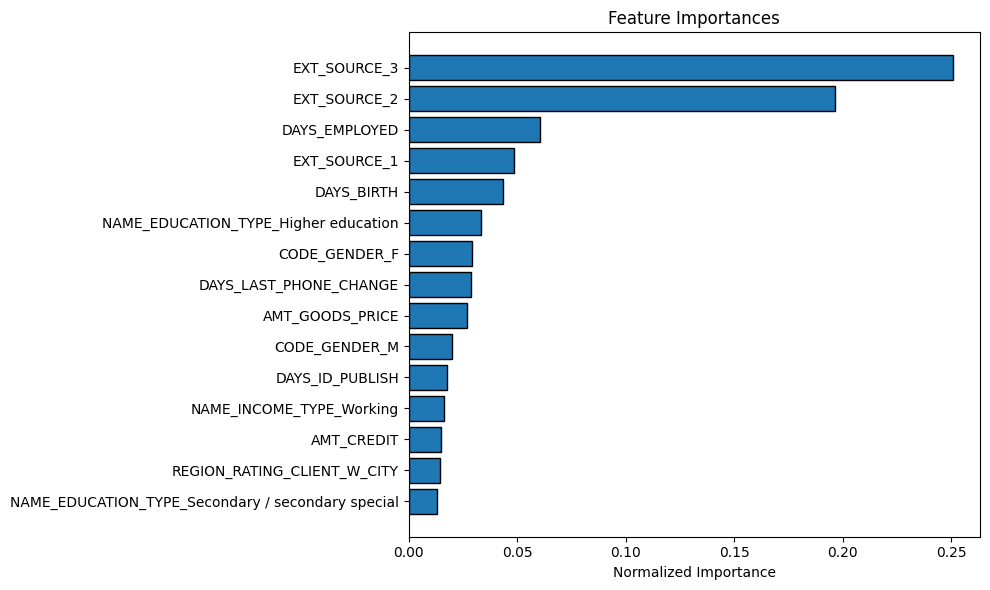

In [30]:
plot_feature_importances(features, random_forest.feature_importances_)

In [31]:
autolog.notebook("This is my first random forest model")

New Iteration number 3 created.

For quick access to the Iteration in the Vectice web app, visit:
https://app.vectice.com/browse/iteration/ITR-9195
Note logged in iteration 3.
File: /Users/bryandaversa/Vectice/GettingStarted/perso/Demo-bank/application_train.csv wrapped successfully.
Dataset 'PHA-4363-application_cleaned' logged in iteration 3.
Dataset 'PHA-4363-app_test_feat' logged in iteration 3.
Dataset 'PHA-4363-train_no_missing' logged in iteration 3.
Dataset 'PHA-4363-test_no_missing' logged in iteration 3.
Model 'PHA-4363-random_forest' logged in iteration 3.
Dataset 'PHA-4363-df_results' logged in iteration 3.
Graph 'Target distribution.png' logged in iteration 3.
Graph 'Failure to repay by age group.png' logged in iteration 3.
Graph 'Correlation.png' logged in iteration 3.
Graph 'feature_importances.png' logged in iteration 3.
Graph 'roc_curve.png' logged in iteration 3.
Graph 'calibration.png' logged in iteration 3.
Graph 'Prediction_distribution.png' logged in iteration 3.
